In [78]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

## 1. Load data

In [2]:
import nltk
from nltk.corpus import brown

In [3]:
nltk.download('brown')

[nltk_data] Downloading package brown to /Users/gg/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [4]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [5]:
corpus = brown.sents(categories='news')

In [6]:
corpus

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

In [7]:
#1. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [8]:
vocabs

['bed',
 'headquarters',
 'credits',
 'Avenue',
 "Nixon's",
 'marketed',
 "Canada's",
 'minutes',
 'Budapest',
 'inning',
 'diehard',
 'running',
 'Dubovskoi',
 '$17',
 'result',
 'nominee',
 'Fears',
 'front',
 '1924',
 'satisfaction',
 '$18.2',
 'Museum',
 'His',
 'terms',
 'Sutherland',
 'Assn.',
 '1.58',
 'constituted',
 'compare',
 'impressions',
 'fighting',
 'Coulson',
 'Tires',
 'deposit',
 'communism',
 'retain',
 'contemptuous',
 'shelters',
 'observer',
 "Case's",
 'Worrell',
 'rough',
 'Mine',
 'drive-in',
 'Exclaimed',
 'Physicians',
 'credit',
 'colonies',
 'Armisteads',
 'drafts',
 'Pappas',
 'Blanche',
 'Noel',
 'Philippine',
 'recipient',
 'Millie',
 'Vickery',
 'lecture',
 '469',
 'pitched',
 'Herb',
 'spun',
 'masses',
 'jumpy',
 'sued',
 'jet',
 'promises',
 'Wally',
 'Vague',
 'Scherer',
 'outline',
 'Vivier',
 'tore',
 'stand-ins',
 'cross-section',
 'valve',
 'tennis',
 'H.',
 'abolish',
 'people',
 '$451,500',
 'Lao',
 'Seidel',
 'either',
 'induce',
 'Chips',
 

In [9]:
len(vocabs)

14394

In [10]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}

In [11]:
print(word2index)

{'bed': 0, 'headquarters': 1, 'credits': 2, 'Avenue': 3, "Nixon's": 4, 'marketed': 5, "Canada's": 6, 'minutes': 7, 'Budapest': 8, 'inning': 9, 'diehard': 10, 'running': 11, 'Dubovskoi': 12, '$17': 13, 'result': 14, 'nominee': 15, 'Fears': 16, 'front': 17, '1924': 18, 'satisfaction': 19, '$18.2': 20, 'Museum': 21, 'His': 22, 'terms': 23, 'Sutherland': 24, 'Assn.': 25, '1.58': 26, 'constituted': 27, 'compare': 28, 'impressions': 29, 'fighting': 30, 'Coulson': 31, 'Tires': 32, 'deposit': 33, 'communism': 34, 'retain': 35, 'contemptuous': 36, 'shelters': 37, 'observer': 38, "Case's": 39, 'Worrell': 40, 'rough': 41, 'Mine': 42, 'drive-in': 43, 'Exclaimed': 44, 'Physicians': 45, 'credit': 46, 'colonies': 47, 'Armisteads': 48, 'drafts': 49, 'Pappas': 50, 'Blanche': 51, 'Noel': 52, 'Philippine': 53, 'recipient': 54, 'Millie': 55, 'Vickery': 56, 'lecture': 57, '469': 58, 'pitched': 59, 'Herb': 60, 'spun': 61, 'masses': 62, 'jumpy': 63, 'sued': 64, 'jet': 65, 'promises': 66, 'Wally': 67, 'Vague'

In [12]:
vocabs.append('<UNK>')

In [13]:
word2index['<UNK>'] = len(vocabs) - 1

In [14]:
index2word = {v:k for k, v in word2index.items()}

In [15]:
index2word[0]

'bed'

## 2. Build Co-occurence Matrix X (Glove)

In [16]:
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
X_i

Counter({'the': 5580,
         ',': 5188,
         '.': 4030,
         'of': 2849,
         'and': 2146,
         'to': 2116,
         'a': 1993,
         'in': 1893,
         'for': 943,
         'The': 806,
         'that': 802,
         '``': 732,
         'is': 732,
         'was': 717,
         "''": 702,
         'on': 657,
         'at': 598,
         'with': 545,
         'be': 526,
         'by': 497,
         'as': 481,
         'he': 451,
         'said': 402,
         'his': 399,
         'will': 389,
         'it': 363,
         'from': 344,
         'are': 328,
         ';': 314,
         'an': 300,
         'has': 300,
         '--': 300,
         'had': 279,
         'who': 268,
         'have': 265,
         'not': 254,
         'Mrs.': 253,
         'were': 252,
         'this': 250,
         'which': 244,
         'would': 244,
         'their': 219,
         'been': 212,
         'they': 205,
         'He': 191,
         'one': 184,
         'I': 179,
         'but'

In [17]:
# Make skip gram of 2 size window
skip_grams = []
for sent in corpus:
    for i in range(2, len(sent) - 2):
        target = sent[i]
        context = [sent[i - 2],sent[i - 1], sent[i + 1],sent[i + 2]]
        for w in context:
            skip_grams.append((target, w))

skip_grams

[('County', 'The'),
 ('County', 'Fulton'),
 ('County', 'Grand'),
 ('County', 'Jury'),
 ('Grand', 'Fulton'),
 ('Grand', 'County'),
 ('Grand', 'Jury'),
 ('Grand', 'said'),
 ('Jury', 'County'),
 ('Jury', 'Grand'),
 ('Jury', 'said'),
 ('Jury', 'Friday'),
 ('said', 'Grand'),
 ('said', 'Jury'),
 ('said', 'Friday'),
 ('said', 'an'),
 ('Friday', 'Jury'),
 ('Friday', 'said'),
 ('Friday', 'an'),
 ('Friday', 'investigation'),
 ('an', 'said'),
 ('an', 'Friday'),
 ('an', 'investigation'),
 ('an', 'of'),
 ('investigation', 'Friday'),
 ('investigation', 'an'),
 ('investigation', 'of'),
 ('investigation', "Atlanta's"),
 ('of', 'an'),
 ('of', 'investigation'),
 ('of', "Atlanta's"),
 ('of', 'recent'),
 ("Atlanta's", 'investigation'),
 ("Atlanta's", 'of'),
 ("Atlanta's", 'recent'),
 ("Atlanta's", 'primary'),
 ('recent', 'of'),
 ('recent', "Atlanta's"),
 ('recent', 'primary'),
 ('recent', 'election'),
 ('primary', "Atlanta's"),
 ('primary', 'recent'),
 ('primary', 'election'),
 ('primary', 'produced'),
 (

In [18]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 2
X_ik_skipgram

Counter({('the', 'of'): 1460,
         ('of', 'the'): 1443,
         ('the', ','): 870,
         (',', 'the'): 855,
         (',', ','): 809,
         ('the', 'in'): 663,
         ('in', 'the'): 659,
         (',', 'and'): 624,
         ('and', ','): 624,
         ('the', 'to'): 594,
         ('to', 'the'): 590,
         ('of', ','): 380,
         (',', 'of'): 377,
         ('and', 'the'): 357,
         ('the', '.'): 354,
         ('the', 'and'): 353,
         ('of', 'a'): 351,
         ('a', 'of'): 346,
         (',', 'a'): 324,
         ('a', ','): 319,
         ('the', 'for'): 280,
         (',', 'in'): 280,
         ('in', ','): 280,
         ('for', 'the'): 279,
         ('the', 'on'): 277,
         ('on', 'the'): 274,
         (',', 'said'): 250,
         ('the', 'that'): 224,
         ('that', 'the'): 222,
         ('to', 'a'): 221,
         ('a', 'to'): 219,
         ('the', 'at'): 210,
         (',', "''"): 209,
         ('at', 'the'): 208,
         ("''", ','): 207,
         

## 3. Weighting function (Glove)

In [19]:
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [20]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

In [21]:
X_ik

{('bed', 'poster'): 2,
 ('poster', 'bed'): 2,
 ('bed', 'out'): 2,
 ('out', 'bed'): 2,
 ('bed', 'with'): 2,
 ('with', 'bed'): 2,
 ('bed', 'or'): 3,
 ('or', 'bed'): 3,
 ('bed', 'and'): 2,
 ('and', 'bed'): 2,
 ('bed', 'of'): 2,
 ('of', 'bed'): 2,
 ('bed', 'against'): 2,
 ('against', 'bed'): 2,
 ('bed', 'a'): 4,
 ('a', 'bed'): 4,
 ('bed', 'arched'): 2,
 ('arched', 'bed'): 2,
 ('headquarters', 'bags'): 2,
 ('bags', 'headquarters'): 2,
 ('headquarters', 'Coral'): 2,
 ('Coral', 'headquarters'): 2,
 ('headquarters', 'is'): 2,
 ('is', 'headquarters'): 2,
 ('headquarters', 'The'): 2,
 ('The', 'headquarters'): 2,
 ('headquarters', 'have'): 2,
 ('have', 'headquarters'): 2,
 ('headquarters', 'here'): 3,
 ('here', 'headquarters'): 3,
 ('headquarters', 'could'): 2,
 ('could', 'headquarters'): 2,
 ('headquarters', 'in'): 4,
 ('in', 'headquarters'): 4,
 ('headquarters', 'with'): 2,
 ('with', 'headquarters'): 2,
 ('headquarters', 'the'): 6,
 ('the', 'headquarters'): 6,
 ('headquarters', 'serves'): 2,
 (

In [22]:
weighting_dic

{('bed', 'bed'): 0.03162277660168379,
 ('bed', 'headquarters'): 0.03162277660168379,
 ('headquarters', 'bed'): 0.03162277660168379,
 ('bed', 'credits'): 0.03162277660168379,
 ('credits', 'bed'): 0.03162277660168379,
 ('bed', 'Avenue'): 0.03162277660168379,
 ('Avenue', 'bed'): 0.03162277660168379,
 ('bed', "Nixon's"): 0.03162277660168379,
 ("Nixon's", 'bed'): 0.03162277660168379,
 ('bed', 'marketed'): 0.03162277660168379,
 ('marketed', 'bed'): 0.03162277660168379,
 ('bed', "Canada's"): 0.03162277660168379,
 ("Canada's", 'bed'): 0.03162277660168379,
 ('bed', 'minutes'): 0.03162277660168379,
 ('minutes', 'bed'): 0.03162277660168379,
 ('bed', 'Budapest'): 0.03162277660168379,
 ('Budapest', 'bed'): 0.03162277660168379,
 ('bed', 'inning'): 0.03162277660168379,
 ('inning', 'bed'): 0.03162277660168379,
 ('bed', 'diehard'): 0.03162277660168379,
 ('diehard', 'bed'): 0.03162277660168379,
 ('bed', 'running'): 0.03162277660168379,
 ('running', 'bed'): 0.03162277660168379,
 ('bed', 'Dubovskoi'): 0.0

## 4. Prepare train data

### Dynamic Random batch window size default = 2

In [23]:
def random_batch(batch_size, word_sequence, window_size=2):
    
    skip_grams = []

    # loop each word sequence
    for sent in word_sequence:
        for i in range(window_size, len(sent) - window_size):
            target = word2index[sent[i]]
            context = [
                word2index[sent[j]]
                for j in range(i - window_size, i + window_size + 1) if j != i
            ]

            for w in context:
                skip_grams.append([target, w])

    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target word
        random_labels.append([skip_grams[i][1]])  # context word

    return np.array(random_inputs), np.array(random_labels)


In [24]:
import math

def random_batch_Glove(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

## 5. Word2Vec (Skipgram )

In [25]:
class Skipgram(nn.Module):

    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)

    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]

        scores = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)

        return nll # negative log likelihood

## 6. Prepare all vocabs

In [26]:
len(vocabs)

14395

In [27]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [28]:
batch_size = 2
#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, len(vocabs))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 14395])

## 7. Word2Vec Negative Sampling

In [29]:
Z = 0.001

In [30]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])

In [31]:
word_count[',']

5188

In [32]:
num_total_words

100554

In [33]:
unigram_table = []

for vo in vocabs:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [34]:
Counter(unigram_table)

Counter({'the': 114,
         ',': 108,
         '.': 89,
         'of': 69,
         'and': 55,
         'to': 55,
         'a': 52,
         'in': 50,
         'for': 30,
         'The': 26,
         'that': 26,
         'is': 24,
         '``': 24,
         "''": 24,
         'was': 24,
         'on': 22,
         'at': 21,
         'with': 19,
         'be': 19,
         'as': 18,
         'by': 18,
         'he': 17,
         'will': 15,
         'said': 15,
         'his': 15,
         'from': 14,
         'it': 14,
         'are': 13,
         ';': 13,
         '--': 12,
         'had': 12,
         'has': 12,
         'an': 12,
         'who': 11,
         'have': 11,
         'not': 11,
         'this': 11,
         'Mrs.': 11,
         'were': 11,
         'their': 10,
         'which': 10,
         'would': 10,
         'they': 9,
         'He': 9,
         'been': 9,
         '(': 8,
         'up': 8,
         'but': 8,
         'one': 8,
         'out': 8,
         'more':

In [35]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    return torch.cat(neg_samples)

In [36]:
class SkipgramNegSampling(nn.Module):

    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]

        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]

        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)

        return -torch.mean(loss)

## 8. Glove

In [37]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## 9.Training

In [38]:
voc_size = len(vocabs)
print(voc_size)

14395


In [39]:
batch_size = 2
emb_size   = 2
model_Skipgram  = Skipgram(voc_size, emb_size)
model_SkipgramNec  = SkipgramNegSampling(voc_size, emb_size)
model_Glove = GloVe(voc_size, emb_size)
optimizer_Skipgram  = optim.Adam(model_Skipgram.parameters(), lr=0.001)
optimizer_SkipgramNec  = optim.Adam(model_SkipgramNec.parameters(), lr=0.001)
optimizer_Glove  = optim.Adam(model_Glove.parameters(), lr=0.001)

In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
import time
num_epochs = 1000
num_neg = 10
# Training for Skipgram
start = time.time()
for epoch in range(num_epochs):
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)  # [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)  # [batch_size, 1]

    optimizer_Skipgram.zero_grad()
    loss = model_Skipgram(input_batch, target_batch, all_vocabs)

    loss.backward()
    optimizer_Skipgram.step()

    if (epoch + 1) % 100 == 0:
        print(f"Skipgram | Epoch: {epoch + 1} | cost: {loss:.6f}")

end = time.time()
epoch_mins, epoch_secs = epoch_time(start, end)
print(f"Time for Skipgram: {epoch_mins}m {epoch_secs}s\n")

# Training for Skipgram with Negative Sampling
start = time.time()
for epoch in range(num_epochs):
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)  # [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)  # [batch_size, 1]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    optimizer_SkipgramNec.zero_grad()
    loss = model_SkipgramNec(input_batch, target_batch, negs_batch)

    loss.backward()
    optimizer_SkipgramNec.step()

    if (epoch + 1) % 100 == 0:
        print(f"Skipgram with Negative Sampling | Epoch: {epoch + 1} | cost: {loss:.6f}")

end = time.time()
epoch_mins, epoch_secs = epoch_time(start, end)
print(f"Time for Skipgram with Negative Sampling: {epoch_mins}m {epoch_secs}s\n")

# Training for GloVe
start = time.time()
for epoch in range(num_epochs):
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch_Glove(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch = torch.LongTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    cooc_batch = torch.FloatTensor(cooc_batch)
    weighting_batch = torch.FloatTensor(weighting_batch) 

    optimizer_Glove.zero_grad()
    loss = model_Glove(input_batch, target_batch, cooc_batch, weighting_batch)

    loss.backward()
    optimizer_Glove.step()

    if (epoch + 1) % 100 == 0:
        print(f"GloVe | Epoch: {epoch + 1} | cost: {loss:.6f}")

end = time.time()
epoch_mins, epoch_secs = epoch_time(start, end)
print(f"Time for GloVe: {epoch_mins}m {epoch_secs}s\n")

Skipgram | Epoch: 100 | cost: 9.553632
Skipgram | Epoch: 200 | cost: 10.783092
Skipgram | Epoch: 300 | cost: 12.649218
Skipgram | Epoch: 400 | cost: 9.999170
Skipgram | Epoch: 500 | cost: 9.448099
Skipgram | Epoch: 600 | cost: 9.998026
Skipgram | Epoch: 700 | cost: 12.098543
Skipgram | Epoch: 800 | cost: 7.777328
Skipgram | Epoch: 900 | cost: 9.945230
Skipgram | Epoch: 1000 | cost: 9.538479
Time for Skipgram: 6m 11s

Skipgram with Negative Sampling | Epoch: 100 | cost: 9.045870
Skipgram with Negative Sampling | Epoch: 200 | cost: 9.986103
Skipgram with Negative Sampling | Epoch: 300 | cost: 10.178074
Skipgram with Negative Sampling | Epoch: 400 | cost: 9.579548
Skipgram with Negative Sampling | Epoch: 500 | cost: 13.317454
Skipgram with Negative Sampling | Epoch: 600 | cost: 8.059203
Skipgram with Negative Sampling | Epoch: 700 | cost: 12.198092
Skipgram with Negative Sampling | Epoch: 800 | cost: 10.213088
Skipgram with Negative Sampling | Epoch: 900 | cost: 10.353754
Skipgram with Ne

## 10. Plot the embeddings using model Glove because it has lowest loss and time.

In [75]:
def get_embed(model, word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_v(word)
    embed_o = model.embedding_u(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

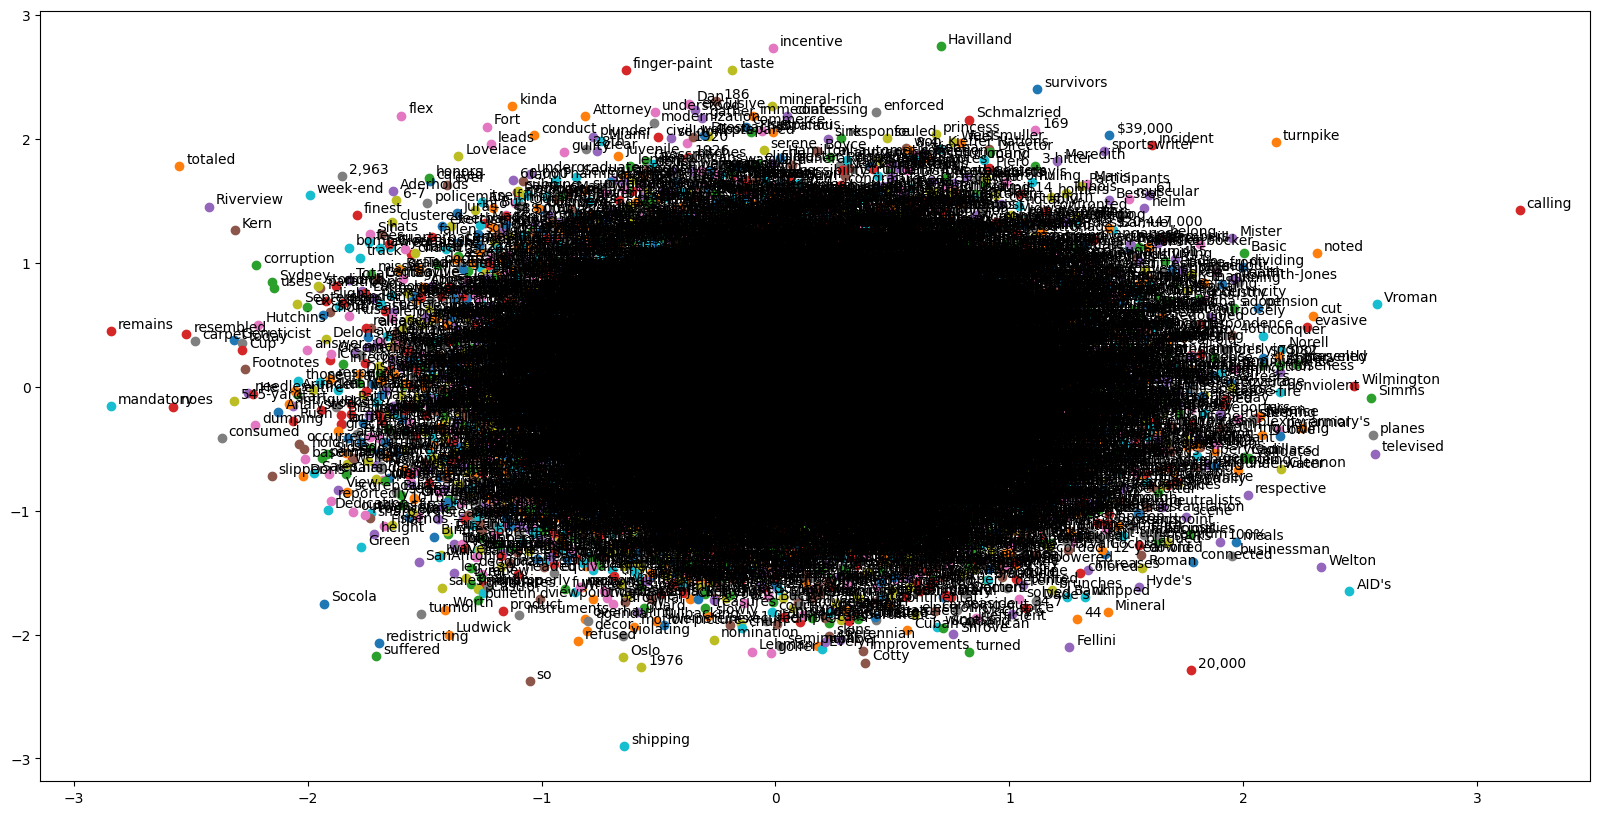

In [77]:
plt.figure(figsize=(20, 10))
for i, word in enumerate(vocabs):
    x, y = get_embed(model_Glove,word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 11. Model comparison and analysis


In [42]:
def analogy_data(file_path):
    semantic = []
    syntactic = []
    section = None

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            
            if line.startswith(":"):
                if line == ": capital-common-countries":
                    section = "semantic"
                elif line == ": gram7-past-tense":
                    section = "syntactic"
                else:
                    section = None
                continue

            if section == "semantic":
                words = line.split()
                if len(words) == 4:
                    semantic.append(words)
            elif section == "syntactic":
                words = line.split()
                if len(words) == 4:
                    syntactic.append(words)

    return semantic, syntactic

In [43]:
file_path = "word-test.v1.txt"
semantic_data, syntactic_data = analogy_data(file_path)

In [44]:
semantic_data

[['Athens', 'Greece', 'Baghdad', 'Iraq'],
 ['Athens', 'Greece', 'Bangkok', 'Thailand'],
 ['Athens', 'Greece', 'Beijing', 'China'],
 ['Athens', 'Greece', 'Berlin', 'Germany'],
 ['Athens', 'Greece', 'Bern', 'Switzerland'],
 ['Athens', 'Greece', 'Cairo', 'Egypt'],
 ['Athens', 'Greece', 'Canberra', 'Australia'],
 ['Athens', 'Greece', 'Hanoi', 'Vietnam'],
 ['Athens', 'Greece', 'Havana', 'Cuba'],
 ['Athens', 'Greece', 'Helsinki', 'Finland'],
 ['Athens', 'Greece', 'Islamabad', 'Pakistan'],
 ['Athens', 'Greece', 'Kabul', 'Afghanistan'],
 ['Athens', 'Greece', 'London', 'England'],
 ['Athens', 'Greece', 'Madrid', 'Spain'],
 ['Athens', 'Greece', 'Moscow', 'Russia'],
 ['Athens', 'Greece', 'Oslo', 'Norway'],
 ['Athens', 'Greece', 'Ottawa', 'Canada'],
 ['Athens', 'Greece', 'Paris', 'France'],
 ['Athens', 'Greece', 'Rome', 'Italy'],
 ['Athens', 'Greece', 'Stockholm', 'Sweden'],
 ['Athens', 'Greece', 'Tehran', 'Iran'],
 ['Athens', 'Greece', 'Tokyo', 'Japan'],
 ['Baghdad', 'Iraq', 'Bangkok', 'Thailand'

In [45]:
syntactic_data

[['dancing', 'danced', 'decreasing', 'decreased'],
 ['dancing', 'danced', 'describing', 'described'],
 ['dancing', 'danced', 'enhancing', 'enhanced'],
 ['dancing', 'danced', 'falling', 'fell'],
 ['dancing', 'danced', 'feeding', 'fed'],
 ['dancing', 'danced', 'flying', 'flew'],
 ['dancing', 'danced', 'generating', 'generated'],
 ['dancing', 'danced', 'going', 'went'],
 ['dancing', 'danced', 'hiding', 'hid'],
 ['dancing', 'danced', 'hitting', 'hit'],
 ['dancing', 'danced', 'implementing', 'implemented'],
 ['dancing', 'danced', 'increasing', 'increased'],
 ['dancing', 'danced', 'jumping', 'jumped'],
 ['dancing', 'danced', 'knowing', 'knew'],
 ['dancing', 'danced', 'listening', 'listened'],
 ['dancing', 'danced', 'looking', 'looked'],
 ['dancing', 'danced', 'moving', 'moved'],
 ['dancing', 'danced', 'paying', 'paid'],
 ['dancing', 'danced', 'playing', 'played'],
 ['dancing', 'danced', 'predicting', 'predicted'],
 ['dancing', 'danced', 'reading', 'read'],
 ['dancing', 'danced', 'running', '

In [116]:
def predict_word(A, B, C, model, word2index, index2word):
    try:
        # Convert words to indices
        A_idx = word2index[A]
        B_idx = word2index[B]
        C_idx = word2index[C]

        # Get embeddings
        embedding_A = model.embedding_v.weight[A_idx].detach().numpy()
        embedding_B = model.embedding_v.weight[B_idx].detach().numpy()
        embedding_C = model.embedding_v.weight[C_idx].detach().numpy()

        # Calculate vector D (predicted)
        D = embedding_B - embedding_A + embedding_C

        # Normalize vector D
        D = D / np.linalg.norm(D)

        # Get all embeddings and normalize them
        all_embeddings = model.embedding_v.weight.detach().numpy()
        all_embeddings_norm = all_embeddings / np.linalg.norm(all_embeddings, axis=1, keepdims=True)

        # Compute cosine similarities for all words
        similarities = np.dot(all_embeddings_norm, D)

        # Get the index of the word with the highest similarity
        best_idx = np.argmax(similarities)

        # Return the predicted word
        return index2word[best_idx]
    except KeyError:
        # If a word is not in the vocabulary, return None
        return None


In [117]:
def evaluate_word_analogy(data, model, word2index, index2word):
    correct = 0
    total = len(data)

    for word1, word2, word3, word4 in data:  # A, B, C, D
        predicted_word = predict_word(word1, word2, word3, model, word2index, index2word)
        if predicted_word == word4:
            correct += 1
    # Compute accuracy
    accuracy = (correct / total) * 100
    return accuracy

In [118]:
def evaluate_gensim_word_analogy(data, model):
    correct = 0
    total = len(data)

    for word1, word2, word3, word4 in data:  # A, B, C, D
        # Convert words to lowercase
        word1, word2, word3, word4 = word1.lower(), word2.lower(), word3.lower(), word4.lower()
        # Skip analogy if any word is missing in the vocabulary
        if not all(word in model.key_to_index for word in [word1, word2, word3]):
            continue
        # Predict the missing word
        predicted_word = model.most_similar(positive=[word2, word3], negative=[word1], topn=1)[0][0]

        # Compare the predicted word with the correct answer
        if predicted_word == word4:
            correct += 1

    # Compute accuracy
    accuracy = (correct / total) * 100
    return accuracy

### Load pre-trained GloVe model from the Gensim library for a comparison

In [119]:
glove_file = '../../glove.6B.100d.txt'
modelGensim = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [267]:
# Evaluate semantic accuracy
semantic_accuracy = evaluate_word_analogy(semantic_data, model_Skipgram, word2index, index2word)
print(f"Semantic Accuracy Skipgram: {semantic_accuracy:.2f}%")
semantic_accuracy = evaluate_word_analogy(semantic_data, model_SkipgramNec, word2index, index2word)
print(f"Semantic Accuracy SkipgramNec: {semantic_accuracy:.2f}%")
semantic_accuracy = evaluate_word_analogy(semantic_data, model_Glove, word2index, index2word)
print(f"Semantic Accuracy Glove: {semantic_accuracy:.2f}%")
semantic_accuracy = evaluate_gensim_word_analogy(semantic_data, modelGensim)
print(f"Semantic Accuracy GloVe Gensim: {semantic_accuracy:.2f}%")

print("=="*20)
# Evaluate syntactic accuracy
syntactic_accuracy = evaluate_word_analogy(syntactic_data, model_Skipgram, word2index, index2word)
print(f"Syntactic Accuracy Skipgram: {syntactic_accuracy:.2f}%")
syntactic_accuracy = evaluate_word_analogy(syntactic_data, model_SkipgramNec, word2index, index2word)
print(f"Syntactic Accuracy SkipgramNec: {syntactic_accuracy:.2f}%")
syntactic_accuracy = evaluate_word_analogy(syntactic_data, model_Glove, word2index, index2word)
print(f"Syntactic Accuracy Glove: {syntactic_accuracy:.2f}%")
syntactic_accuracy = evaluate_gensim_word_analogy(syntactic_data, modelGensim)
print(f"Syntactic Accuracy GloVe Gensim: {syntactic_accuracy:.2f}%")

Semantic Accuracy Skipgram: 0.00%
Semantic Accuracy SkipgramNec: 0.00%
Semantic Accuracy Glove: 0.00%
Semantic Accuracy GloVe Gensim: 93.87%
Syntactic Accuracy Skipgram: 0.00%
Syntactic Accuracy SkipgramNec: 0.00%
Syntactic Accuracy Glove: 0.00%
Syntactic Accuracy GloVe Gensim: 55.45%


## 12. Use the similarity dataset (wordsim_similarity_goldstandard.txt) to find the correlation between models

In [121]:
# Load the wordsim dataset
file_path = 'wordsim_similarity_goldstandard.txt'
wordsim_data = pd.read_csv(file_path, sep='\t', header=None, names=["word1", "word2", "Human(mean)"])

print(wordsim_data.head())

        word1  word2  Human(mean)
0       tiger    cat         7.35
1       tiger  tiger        10.00
2       plane    car         5.77
3       train    car         6.31
4  television  radio         6.77


In [220]:
def cosine_similarity(A, B):
    dot_product = np.dot(A.flatten(), B.flatten())
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

In [225]:
def compute_similarity(word1, word2, model, word2index):
    if word1 in word2index and word2 in word2index:
        # Get embeddings
        embedding1 = model.embedding_v(torch.tensor([word2index[word1]])).detach().numpy()
        embedding2 = model.embedding_v(torch.tensor([word2index[word2]])).detach().numpy()
        
        # Compute cosine similarity
        similarity = cosine_similarity(embedding1,embedding2)
        return similarity

In [226]:
def compute_similarity_gensim(word1, word2, model):
    if word1 in model.key_to_index and word2 in model.key_to_index:
        # Gensim similarity method
        similarity = model.similarity(word1, word2)
        return similarity

In [227]:
from scipy.stats import spearmanr

def evaluate_correlation(data, model, word2index=None, model_type="custom"):
    predicted_similarities = []
    human_similarities = []

    for _, row in data.iterrows():
        word1, word2, human_similarity = row["word1"], row["word2"], row["Human(mean)"]

        # Compute model-based similarity
        if model_type == "gensim":
            similarity = compute_similarity_gensim(word1, word2, model)
        else:
            similarity = compute_similarity(word1, word2, model, word2index)

        # Collect scores if similarity is valid
        if similarity is not None:
            predicted_similarities.append(similarity)
            human_similarities.append(human_similarity)

    correlation = spearmanr(predicted_similarities, human_similarities).correlation
    return correlation

In [228]:
correlation = evaluate_correlation(wordsim_data, model_Skipgram, word2index, model_type="")
print(f"Correlation Skipgram Model : {correlation:.4f}")
correlation = evaluate_correlation(wordsim_data, model_SkipgramNec, word2index, model_type="")
print(f"Correlation Skipgram with negative sampling Model : {correlation:.4f}")
correlation = evaluate_correlation(wordsim_data, model_Glove, word2index, model_type="")
print(f"Correlation Glove Model : {correlation:.4f}")
correlation = evaluate_correlation(wordsim_data, modelGensim, word2index, model_type="gensim")
print(f"Correlation Glove(Gensim) Model : {correlation:.4f}")

Correlation Skipgram Model : -0.1328
Correlation Skipgram with negative sampling Model : 0.1604
Correlation Glove Model : 0.0726
Correlation Glove(Gensim) Model : 0.6019


## 13. Inference with skipgram negative sampling model.

### I choose skipgram with negative sampling because it have highest correlation scores with 0.1604 and i ignore pretrained model (Glove(Gensim)).

In [262]:
def find_top_similar_words(input_word, model, vocabs, word2index, top_n=10):
    word_similarities = {}

    try:
        input_embed = get_embed(model, input_word)

        # Ensure input_embed is a NumPy array
        if isinstance(input_embed, tuple):
            input_embed = np.array(input_embed)

        for word in vocabs:
            if word in word2index:  # Check if the word is in the vocabulary
                word_embed = get_embed(model, word)

                # Ensure word_embed is a NumPy array
                if isinstance(word_embed, tuple):
                    word_embed = np.array(word_embed)

                # Compute cosine similarity
                similarity = cosine_similarity(input_embed, word_embed)

                # Store similarity in the dictionary
                word_similarities[word] = similarity

        # Sort words by similarity in descending order
        sorted_similarities = sorted(word_similarities.items(), key=lambda x: x[1], reverse=True)

        # Return the top 10 most similar words
        return sorted_similarities[:top_n]

    except KeyError:
        return "This word is not in the vocabulary. Please try another word."
    except Exception as e:
        return f"An error occurred: {str(e)}"


In [265]:
similar_words = find_top_similar_words("test", model_SkipgramNec, vocabs, word2index, top_n=10)
print(similar_words)

[('test', 0.9999999999999999), ('target', 0.999999989670677), ('Both', 0.9999998898977447), ('post', 0.9999998780371875), ('Damascus', 0.9999998603798158), ('Hester', 0.9999998170392432), ('Wagner', 0.9999997570797875), ('label', 0.9999997552070898), ('springboard', 0.9999997353650147), ('waiting', 0.9999994759321814)]


## 14. Save model

In [179]:
# Save model Skipgram with Negative Sampling
torch.save(model_SkipgramNec.state_dict(), "model_skipgram_neg.pth")

In [266]:
import json

with open("./json/word2index.json", "w") as f:
    json.dump(word2index, f)

with open("./json/vocabs.json", "w") as f:
    json.dump(vocabs, f)